<a href="https://colab.research.google.com/github/Jailior/fashion-mnist-project/blob/main/fashion_mnist_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Computer Vision - FashionMNIST

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


# Dataset

The dataset we're going to use is the FashionMNIST dataset from torchvision.datasets:
https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST


In [2]:
# Training dataset
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

# Testing dataset
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.3MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 23.2MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
# Train and test split
len(train_data), len(test_data)

(60000, 10000)

In [4]:
# Class names
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
# How a training example looks like
image, label = train_data[0]
print(f"Image shape: {image.shape} => [colour channels, height, width]")
print(f"Label : {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) => [colour channels, height, width]
Label : Ankle boot


(-0.5, 27.5, 27.5, -0.5)

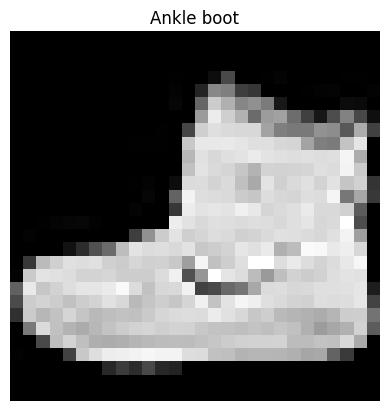

In [6]:
# Plot to show image example
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

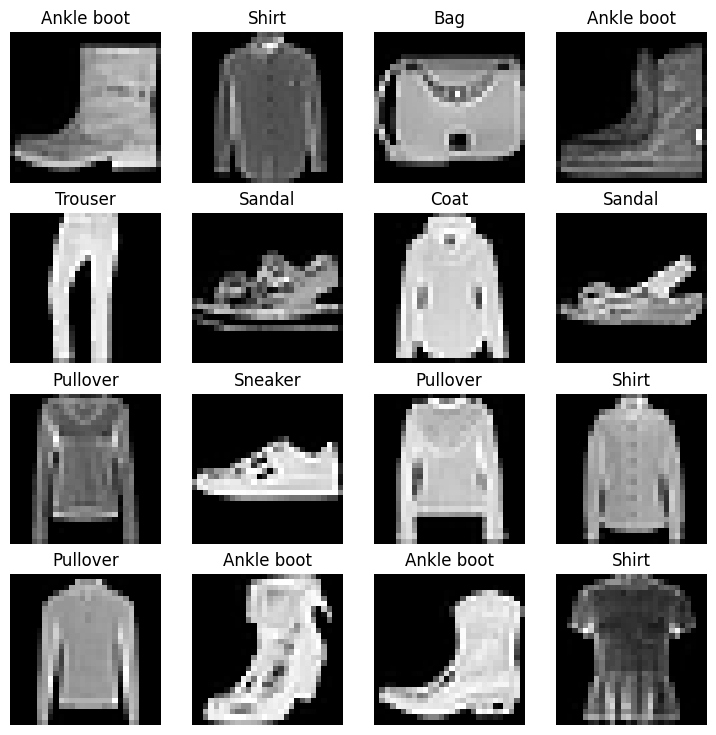

In [7]:
# Some other examples
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows*cols + 1):
  rand_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label_ = train_data[rand_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label_])
  plt.axis(False)

In [8]:
# Dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)


In [9]:
# Turn to iterables
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

# Baseline Model

In [10]:
class FashionMNISTModel0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [11]:
# Set up model
torch.manual_seed(42)

model_0 = FashionMNISTModel0(
    input_shape=784, # 28 by 28
    hidden_units=10,
    output_shape=len(class_names)
).to("cpu")

model_0

FashionMNISTModel0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

## Loss function, optimizer and evaluation metrics

In [12]:
## Adapted from https://www.learnpytorch.io/02_pytorch_classification/
# Calculate accuracy between true values and predictions
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [13]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [14]:
# Tracking runtimes of model
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """
  Prints difference between start and end time
  """
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

# Training and testing baseline model

In [15]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n")

  train_loss = 0

  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()

    y_pred = model_0(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0:
      print(f"Samples: {batch * len(X)} out of {len(train_dataloader.dataset)}\n")

  train_loss /= len(train_dataloader)

  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred = model_0(X_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}")

train_time_end = timer()
total_train_time_model_0 = print_train_time(start=train_time_start, end=train_time_end, device = str(next(model_0.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0

Samples: 0 out of 60000

Samples: 12800 out of 60000

Samples: 25600 out of 60000

Samples: 38400 out of 60000

Samples: 51200 out of 60000

Train loss: 0.5904 | Test loss: 0.5095 | Test acc: 82.04
Epoch: 1

Samples: 0 out of 60000

Samples: 12800 out of 60000

Samples: 25600 out of 60000

Samples: 38400 out of 60000

Samples: 51200 out of 60000

Train loss: 0.4763 | Test loss: 0.4799 | Test acc: 83.20
Epoch: 2

Samples: 0 out of 60000

Samples: 12800 out of 60000

Samples: 25600 out of 60000

Samples: 38400 out of 60000

Samples: 51200 out of 60000

Train loss: 0.4550 | Test loss: 0.4766 | Test acc: 83.43
Train time on cpu: 32.542 seconds


## Model Evaluation

In [16]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = "cpu"):
  """
  Return a dictionary containing model predictions on data_loader
  """
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

In [17]:
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

{'model_name': 'FashionMNISTModel0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [18]:
# Start running on GPU, so including device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Model 1: Non-linearity

In [19]:
class FashionMNISTModel1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x):
    return self.layer_stack(x)

In [20]:
# Set up model
torch.manual_seed(42)

model_1 = FashionMNISTModel1(
    input_shape=784,
    hidden_units = 10,
    output_shape=len(class_names)
).to(device)

model_1

FashionMNISTModel1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [21]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

## Functionizing training and testing loops

In [22]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """
  Performs training step on model, training on data_loader
  """
  train_loss, train_acc = 0, 0

  model.train()

  for batch, (X, y) in enumerate(data_loader):

      X, y = X.to(device), y.to(device)

      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      train_loss += loss
      train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [23]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """
  Performs testing step on model going over data_loader
  """

  test_loss, test_acc = 0, 0

  model.eval()

  with torch.inference_mode():
    for X_test, y_test in data_loader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_pred = model(X_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
  print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [24]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n")

  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn)

  test_step(model=model_1,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn)

train_time_end = timer()
total_train_time_model_1 = print_train_time(start=train_time_start, end=train_time_end, device = str(next(model_1.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0

Train loss: 1.09199 | Train acc: 61.34%
Test loss: 0.95636 | Test acc: 65.00%

Epoch: 1

Train loss: 0.78101 | Train acc: 71.93%
Test loss: 0.72227 | Test acc: 73.91%

Epoch: 2

Train loss: 0.67027 | Train acc: 75.94%
Test loss: 0.68500 | Test acc: 75.02%

Train time on cuda:0: 27.586 seconds


In [25]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_1_results

{'model_name': 'FashionMNISTModel1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [26]:
model_0_results

{'model_name': 'FashionMNISTModel0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

# Model 2 - Convolution Neural Network (CNN)

In [27]:
class FashionMNISTModel2(nn.Module):
  """
    TinyVGG model architecture
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [28]:
# Setup model
torch.manual_seed(42)
model_2 = FashionMNISTModel2(input_shape=1,
                             hidden_units=10,
                             output_shape=len(class_names)).to(device)

In [29]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.1)

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_time_start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n")

  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             optimizer=optimizer,
             device=device)

  test_step(model=model_2,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
             optimizer=optimizer,
             device=device)

train_time_end = timer()
total_train_time_model_2 = print_train_time(start=train_time_start, end=train_time_end, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0

Train loss: 0.59619 | Train acc: 78.29%
Test loss: 0.39883 | Test acc: 85.66%

Epoch: 1

Train loss: 0.36220 | Train acc: 86.94%
Test loss: 0.35729 | Test acc: 86.45%

Epoch: 2

Train loss: 0.32398 | Train acc: 88.23%
Test loss: 0.33324 | Test acc: 88.08%

Train time on cuda: 35.474 seconds


In [31]:
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_2_results

{'model_name': 'FashionMNISTModel2',
 'model_loss': 0.333239883184433,
 'model_acc': 88.07907348242811}

In [32]:
model_0_results

{'model_name': 'FashionMNISTModel0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [34]:
# Comparing results
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModel0,0.476639,83.426518,32.542397
1,FashionMNISTModel1,0.685001,75.019968,27.585752
2,FashionMNISTModel2,0.333240,88.079073,35.474013


Text(0, 0.5, 'model')

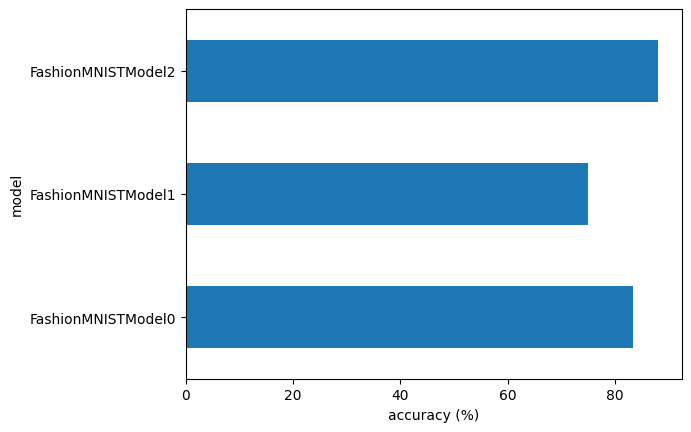

In [36]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

## Prediction evaluation with confusion matrix

In [40]:
from tqdm.auto import tqdm

y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

  0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [42]:
try:
  import torchmetrics
except:
  !pip install -q torchmetrics
  import torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 18.4 MB/s eta 0:00:00


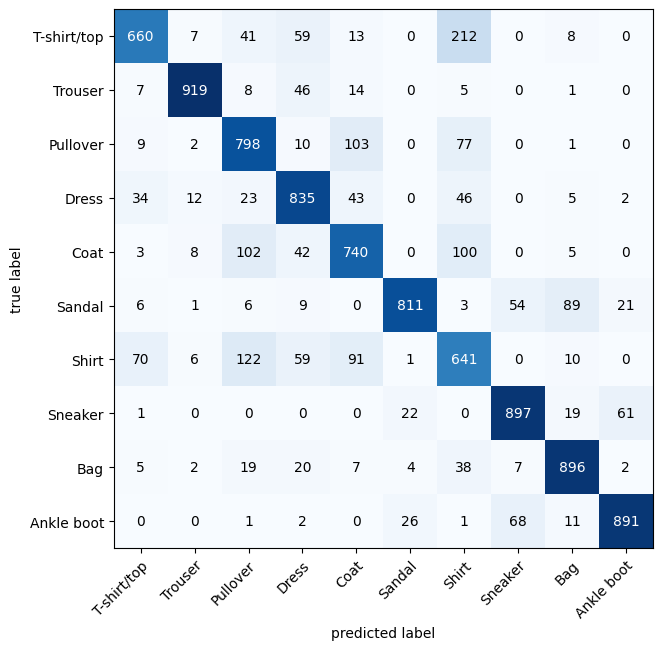

In [47]:
from torchmetrics.classification import MulticlassConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = MulticlassConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

fig, axis = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

## Saving best performing model

In [49]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "FashionMNISTCNNModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)